# Extractive Text Summarization Of Wikipedia Articles

## Import Required Libraries

In [1]:
import time

import re

import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
sw_set = set(stopwords.words("english"))
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {num_cores}")

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from copy import deepcopy

from rouge_score import rouge_scorer

import pandas as pd

Number of Cores: 8


## Function to Webscrapte Wikipedia Article

In [2]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/USA"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

## Function to Pre-process Web Scraped Wikipedia Article

In [3]:
def preprocess_article(article, min_length = 5):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    final_article_st = []
    for sentence in article_st:
        original_sentence = deepcopy(sentence)
        #print(sentence)
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        #print(sentence)
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        #print(sentence)
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        #print(sentence)
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anything between [] including []
        #print(sentence)
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        #print(sentence)
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        #print(sentence)
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        if len(sentence) >= min_length:
            sentence = (" ").join(sentence)
            pp_article_st.append(sentence)
            final_article_st.append(original_sentence)
    return final_article_st, pp_article_st

## Using the two function above to extract Wikipedia Article about USA

In [5]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/USA")
article_st, pp_article_st = preprocess_article(article_text)

In [6]:
pp_string = (" ").join(pp_article_st)

In [7]:
article_st[0]

'\n\ncoordinates: 40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.'

In [10]:
pp_article_st[0:5]

['coordinate 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession',
 '3 8 million square mile 9 8 million square kilometer world third fourth largest country total area',
 'united state share significant land border canada north mexico south well limited maritime border bahamas cuba russia',
 'population 331 million people third populous country world']

## Generate Word Clouds For Raw and Preprocessed Wikipedia Article about USA

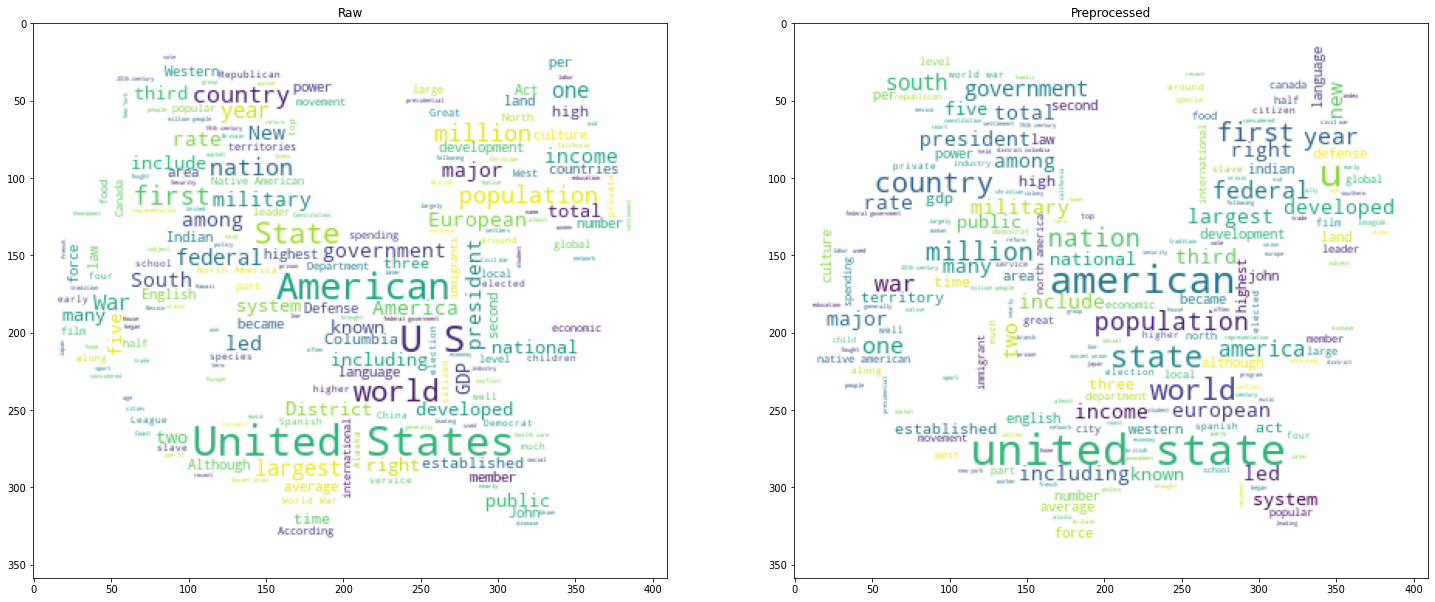

In [11]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

## Define Number of Lines for Summary, This will also be use as K for LSA

In [12]:
#define the summary length
#This could be also though of as number of 
#import topics to be used in the summary
N_LINE = 10

## Generate Feaure Matrixes and Summaries For UNI-GRAM (1-GRAM) Occurence

In [13]:
#1,1(unigrams only)  1,2(unigrams and bigrams) 2,2(bigrams only)
count_vectorizer = CountVectorizer(ngram_range=(1,1)) 
count_vectorizer.fit(pp_article_st)
X = count_vectorizer.transform(pp_article_st)

In [14]:
#perform Latent Semantic Analysis (LSA)
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100)

In [15]:
U.shape #document-topic

(594, 10)

In [16]:
VT.shape #topic-term

(10, 3118)

In [17]:
SIGMA.shape # topic - topic sparse matrix

(10,)

In [18]:
scores = np.sqrt(np.dot(U**2,SIGMA**2))

In [19]:
scores.shape

(594,)

In [20]:
#get index of highest scores
top_scores_index = np.argsort(scores)

In [21]:
#sort the indexes in descending order
top_scores_index = top_scores_index[::-1]

In [22]:
#get top N Scores index
top_scores_index = top_scores_index[0:N_LINE]

In [23]:
top_scores_index

array([464, 569, 447, 274, 431, 395, 470, 345,  11, 141], dtype=int64)

In [24]:
scores[top_scores_index]

array([8.16003732, 7.39382445, 7.08611199, 6.27978792, 4.49961066,
       4.47066756, 4.32349431, 4.28720165, 4.24133492, 4.18842732])

In [25]:
article_array = np.array(article_st)

In [26]:
bow_sum = article_array[top_scores_index]

In [27]:
bow_sum = list(bow_sum)

In [28]:
len(bow_sum)

10

In [29]:
bow_sum_unigram = (" ").join(bow_sum)

In [30]:
bow_sum_unigram

'[424]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii." [530] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). other languages spoken at home by one million people or more include chinese (2.8 million), tagalog (1.6 million), vietnamese (1.4 million), french (1.3 million), korean (1.

In [31]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer.fit(pp_article_st)
X = tfidf_vectorizer.transform(pp_article_st)

In [32]:
#perform LSA
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) 

In [33]:
U.shape #document-topic

(594, 10)

In [34]:
VT.shape #topic-term

(10, 3118)

In [35]:
SIGMA.shape # topic - topic sparse matrix

(10,)

In [36]:
scores = np.sqrt(np.dot(U**2,SIGMA**2))

In [37]:
scores.shape

(594,)

In [38]:
#get index of highest scores
top_scores_index = np.argsort(scores)

In [39]:
#sort the indexes in descending order
top_scores_index = top_scores_index[::-1]

In [40]:
#get top N Scores index
top_scores_index = top_scores_index[0:N_LINE]

In [41]:
top_scores_index

array([447, 301, 452, 255,  12, 263,  11, 253,  22,   4], dtype=int64)

In [42]:
scores[top_scores_index]

array([0.76550151, 0.74570328, 0.71002491, 0.67924685, 0.67597847,
       0.64960397, 0.62409813, 0.61689164, 0.59771023, 0.58581597])

In [43]:
article_array = np.array(article_st)

In [44]:
tfidf_sum = article_array[top_scores_index]

In [45]:
tfidf_sum = list(tfidf_sum)

In [46]:
len(tfidf_sum)

10

In [47]:
tfidf_sum_unigram = (" ").join(tfidf_sum)

In [48]:
tfidf_sum_unigram

"other languages spoken at home by one million people or more include chinese (2.8 million), tagalog (1.6 million), vietnamese (1.4 million), french (1.3 million), korean (1.1 million), and german (1 million). the united states is one of the few countries in the world to do so. the united states has the world's largest christian population. the district of columbia and the five major u.s. territories do not have senators. during the cold war, the united states fought the korean war and the vietnam war but avoided direct military conflict with the soviet union. [231] the states and the district of columbia choose the president of the united states. the spanish–american war and world war i established the u.s. as a world power, a status confirmed by the outcome of world war ii. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. by value, the united states is the world's largest importer and second-largest e

## TF-IDF LDA Unigram

In [70]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer.fit(pp_article_st)
X = tfidf_vectorizer.transform(pp_article_st)
X.shape

(594, 3118)

In [71]:
lda_model = LDA(n_components=N_LINE, random_state=0, max_iter = 50)
lda_model.fit(X)

LatentDirichletAllocation(max_iter=50, random_state=0)

In [72]:
document_topic = lda_model.transform(X)
document_topic.shape #Document Topic

(594, 10)

In [92]:
document_topic[0].sum()

1.0

In [73]:
vocab = np.array(tfidf_vectorizer.get_feature_names())
vocab.shape

(3118,)

In [75]:
topic_word = lda_model.components_ # topic - word
topic_word.shape

(10, 3118)

In [80]:
topic_word[0].shape

(3118,)

array([0.61167809, 0.1       , 0.3655732 , 0.1       , 0.5071052 ])

In [110]:
top_features_indices = topic_word[0].argsort()[ : -10 - 1 : -1 ] # get indices by argsort() 

In [111]:
top_features_indices.shape

(10,)

In [116]:
top_features = vocab[top_features_indices] #alternateively: top_features = [vocab[i] for i in top_features_indices]
top_features

array(['state', 'first', 'american', 'united', 'wave', 'country',
       'million', 'population', 'since', 'public'], dtype='<U17')

In [118]:
weights = topic_word[0][top_features_indices]
weights

array([1.68401107, 1.5006675 , 1.46723868, 1.35865085, 1.33535575,
       1.28753927, 1.22749969, 1.12189764, 1.10345286, 1.06642577])

In [13]:
## Generate Feaure Matrixes and Summaries For BI-GRAM (2-GRAM) Occurence

## Generate Feaure Matrixes and Summaries For BI-GRAM (2-GRAM) Occurence

### BOW

In [44]:
count_vectorizer = CountVectorizer(ngram_range=(2,2))  #instantiate N-GRAM BOW
count_vectorizer.fit(pp_article_st) #train N-GRAM BOW Features generator model
X = count_vectorizer.transform(pp_article_st) #create N-GRAM BOW feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
bow_sum = article_array[top_scores_index] #get top N scoring sentences
bow_sum = list(bow_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(bow_sum)} \n")
bow_sum_bigram = (" ").join(bow_sum) #convert list to single string
bow_sum_bigram

Number of Lines in Summary: 10 



"[504] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men's national soccer team qualified for ten world cups and the women's team has won the fifa women's world cup four times; major league soccer is the sport's highest league in the united states (featuring 23 american and three canadian teams). notable films topping the american film institute's afi 100 list include orson welles's citizen kane (1941), which is frequently cited as the greatest film of all time,[496][497] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler's list (1993), singin' in the rain (1952), it's a wonderful life (1946) and sunset boulevard (1950). [348] today, american forces can be rapidly deployed by the air force's large fleet of transport aircraft, the navy's 11 active aircraft carriers, and mari

### TF-IDF

In [45]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))  #instantiate N-GRAM TF-IDF
tfidf_vectorizer.fit(pp_article_st) #train N-GRAM TF-IDF Features generator model
X = tfidf_vectorizer.transform(pp_article_st) #create N-GRAM TF-IDF feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
tfidf_sum = article_array[top_scores_index] #get top N scoring sentences
tfidf_sum = list(tfidf_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(tfidf_sum)} \n")
tfidf_sum_bigram = (" ").join(tfidf_sum) #convert list to single string
tfidf_sum_bigram

Number of Lines in Summary: 10 



"it is a permanent member of the united nations security council. it is a permanent member of the united nations security council. during the cold war, the united states and the soviet union engaged in various proxy wars but avoided direct military conflict. the district of columbia and the five major u.s. territories do not have senators. by value, the united states is the world's largest importer and the second-largest exporter of goods. new york city is home to the united nations headquarters. the united states has the world's largest christian population. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. while the u.s. and soviet union engaged in proxy wars and developed powerful nuclear arsenals, the two countries avoided direct military conflict. the spanish–american war and world war i established the u.s. as a world power, a status confirmed by the outcome of world war ii."

## Generate Feaure Matrixes and Summaries For Tri-GRAM (3-GRAM) Occurence

### BOW

In [46]:
count_vectorizer = CountVectorizer(ngram_range=(3,3))  #instantiate N-GRAM BOW
count_vectorizer.fit(pp_article_st) #train N-GRAM BOW Features generator model
X = count_vectorizer.transform(pp_article_st) #create N-GRAM BOW feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
bow_sum = article_array[top_scores_index] #get top N scoring sentences
bow_sum = list(bow_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(bow_sum)} \n")
bow_sum_trigram = (" ").join(bow_sum) #convert list to single string
bow_sum_trigram

Number of Lines in Summary: 10 



'notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[496][497] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [504] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). american pop stars such as bing crosby, elvis presley, michael jackson and madonna have become global celebrities,[482] as have contemporary music

### TF-IDF

In [47]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3))  #instantiate N-GRAM TF-IDF
tfidf_vectorizer.fit(pp_article_st) #train N-GRAM TF-IDF Features generator model
X = tfidf_vectorizer.transform(pp_article_st) #create N-GRAM TF-IDF feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
tfidf_sum = article_array[top_scores_index] #get top N scoring sentences
tfidf_sum = list(tfidf_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(tfidf_sum)} \n")
tfidf_sum_trigram = (" ").join(tfidf_sum) #convert list to single string
tfidf_sum_trigram

Number of Lines in Summary: 10 



"it is a permanent member of the united nations security council. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. [516]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. the united states has the world's largest christian population. [283][284]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. by value, the united states is the world's largest importer and the second-largest exporter of goods. the united states is a federal republic and a representative democracy with three separate

## Generate Feaure Matrixes and Summaries For (4-GRAM) Occurence

### BOW

In [48]:
count_vectorizer = CountVectorizer(ngram_range=(4,4))  #instantiate N-GRAM BOW
count_vectorizer.fit(pp_article_st) #train N-GRAM BOW Features generator model
X = count_vectorizer.transform(pp_article_st) #create N-GRAM BOW feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
bow_sum = article_array[top_scores_index] #get top N scoring sentences
bow_sum = list(bow_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(bow_sum)} \n")
bow_sum_4gram = (" ").join(bow_sum) #convert list to single string
bow_sum_4gram

Number of Lines in Summary: 10 



'notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[496][497] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [504] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). american pop stars such as bing crosby, elvis presley, michael jackson and madonna have become global celebrities,[482] as have contemporary music

### TF-IDF

In [49]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(4,4))  #instantiate N-GRAM TF-IDF
tfidf_vectorizer.fit(pp_article_st) #train N-GRAM TF-IDF Features generator model
X = tfidf_vectorizer.transform(pp_article_st) #create N-GRAM TF-IDF feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
tfidf_sum = article_array[top_scores_index] #get top N scoring sentences
tfidf_sum = list(tfidf_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(tfidf_sum)} \n")
tfidf_sum_4gram = (" ").join(tfidf_sum) #convert list to single string
tfidf_sum_4gram

Number of Lines in Summary: 10 



"it is a permanent member of the united nations security council. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. [516]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. by value, the united states is the world's largest importer and the second-largest exporter of goods. the united states has the world's largest christian population. [327] it works closely with fellow nato members on military and security issues and with its neighbors through the organization of american states and free trade agreements such as the trilateral north american free trade agreement with 

## Generate Feaure Matrixes and Summaries For (5-GRAM) Occurence

### BOW

In [50]:
count_vectorizer = CountVectorizer(ngram_range=(5,5))  #instantiate N-GRAM BOW
count_vectorizer.fit(pp_article_st) #train N-GRAM BOW Features generator model
X = count_vectorizer.transform(pp_article_st) #create N-GRAM BOW feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
bow_sum = article_array[top_scores_index] #get top N scoring sentences
bow_sum = list(bow_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(bow_sum)} \n")
bow_sum_5gram = (" ").join(bow_sum) #convert list to single string
bow_sum_5gram

Number of Lines in Summary: 10 



'notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[496][497] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [504] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). american pop stars such as bing crosby, elvis presley, michael jackson and madonna have become global celebrities,[482] as have contemporary music

### TF-IDF

In [51]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(5,5))  #instantiate N-GRAM TF-IDF
tfidf_vectorizer.fit(pp_article_st) #train N-GRAM TF-IDF Features generator model
X = tfidf_vectorizer.transform(pp_article_st) #create N-GRAM TF-IDF feature matrix
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100) #perform Latent Semantic Analysis (LSA)
scores = np.sqrt(np.dot(U**2,SIGMA**2)) #generate scores for all sentences
top_scores_index = np.argsort(scores) #get index of highest scores
top_scores_index = top_scores_index[::-1] #sort the indexes in descending order
top_scores_index = top_scores_index[0:N_LINE] #get top N Scores index
article_array = np.array(article_st) #convert list to array for indexing purpose
tfidf_sum = article_array[top_scores_index] #get top N scoring sentences
tfidf_sum = list(tfidf_sum) #convert array back to list
print(f"Number of Lines in Summary: {len(tfidf_sum)} \n")
tfidf_sum_5gram = (" ").join(tfidf_sum) #convert list to single string
tfidf_sum_5gram

Number of Lines in Summary: 10 



'it is a permanent member of the united nations security council. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. [516]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. it consists of 50 states, a federal district, five major self-governing territories, 326 indian reservations, and some minor possessions. [283][284]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. [327] it works closely with fellow nato members on military and security issues and with its neighbors through the org

## Summaries Gnerated Via Survery

In [52]:
survey_summary1 = """The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world's largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of universal health care. In 2018, there were almost 90 million immigrants and U.S.-born children of immigrants in the United States, accounting for 28% of the overall U.S. population. The country is one of the five recognized nuclear weapons states and one of nine countries to possess nuclear weapons. The American fast food industry, the world's largest, pioneered the drive-through format in the 1940s. American football is by several measures the most popular spectator sport in the United States."""
survey_summary1

'The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world\'s largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of un

In [53]:
survey_summary2 = """The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. The United States is a highly developed country, and continuously ranks high in measures of socioeconomic performance. Making up more than a third of global military spending, it is the foremost military power in the world and is a leading political, cultural, and scientific force internationally. """
survey_summary2

"The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The U

## Evaluation of Generated Summaries using ROUGE-N Metric and Survey Summary 2

### 1-GRAM

In [54]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)

In [55]:
score_1gram_bow = scorer.score(bow_sum_unigram,survey_summary2)["rouge1"].recall #BOW
score_1gram_bow

0.22943722943722944

In [56]:
score_1gram_tfidf = scorer.score(tfidf_sum_unigram,survey_summary2)["rouge1"].recall #TF-IDF
score_1gram_tfidf

0.4383561643835616

### 2-GRAM

In [57]:
scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=False)

In [58]:
score_2gram_bow = scorer.score(bow_sum_bigram,survey_summary2)["rouge2"].recall #BOW
score_2gram_bow

0.08148148148148149

In [59]:
score_2gram_tfidf = scorer.score(tfidf_sum_bigram,survey_summary2)["rouge2"].recall #TF-IDF
score_2gram_tfidf

0.13690476190476192

### 3-GRAM

In [60]:
scorer = rouge_scorer.RougeScorer(['rouge3'], use_stemmer=False)

In [61]:
score_3gram_bow = scorer.score(bow_sum_trigram,survey_summary2)["rouge3"].recall #BOW
score_3gram_bow

0.012237762237762238

In [62]:
score_3gram_tfidf = scorer.score(tfidf_sum_trigram,survey_summary2)["rouge3"].recall #TF-IDF
score_3gram_tfidf

0.19298245614035087

### 4-GRAM

In [63]:
scorer = rouge_scorer.RougeScorer(['rouge4'], use_stemmer=False)

In [64]:
score_4gram_bow = scorer.score(bow_sum_4gram,survey_summary2)["rouge4"].recall #BOW
score_4gram_bow

0.0

In [65]:
score_4gram_tfidf = scorer.score(tfidf_sum_4gram,survey_summary2)["rouge4"].recall #TF-IDF
score_4gram_tfidf

0.010362694300518135

### 5-GRAM

In [66]:
scorer = rouge_scorer.RougeScorer(['rouge5'], use_stemmer=False)

In [67]:
score_5gram_bow = scorer.score(bow_sum_5gram,survey_summary2)["rouge5"].recall #BOW
score_5gram_bow

0.0

In [68]:
score_5gram_tfidf = scorer.score(tfidf_sum_5gram,survey_summary2)["rouge5"].recall #TF-IDF
score_5gram_tfidf

0.09223300970873786

<h2> Comparision of N-GRAM and Feature Extraction Scheme Using ROUGE-N Recall Scores </h2>  

In [69]:
comparision_df = pd.DataFrame()

In [70]:
comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

In [71]:
comparision_df["BOW"] = [score_1gram_bow,score_2gram_bow,score_3gram_bow,score_4gram_bow,score_5gram_bow]

In [72]:
comparision_df["TF-IDF"] = [score_1gram_tfidf,score_2gram_tfidf,score_3gram_tfidf,score_4gram_tfidf,score_5gram_tfidf]

In [73]:
comparision_df

,N-Gram Range,BOW,TF-IDF
0,1-Gram,0.229437,0.438356
1,2-Gram,0.081481,0.136905
2,3-Gram,0.012238,0.192982
3,4-Gram,0.000000,0.010363
4,5-Gram,0.000000,0.092233


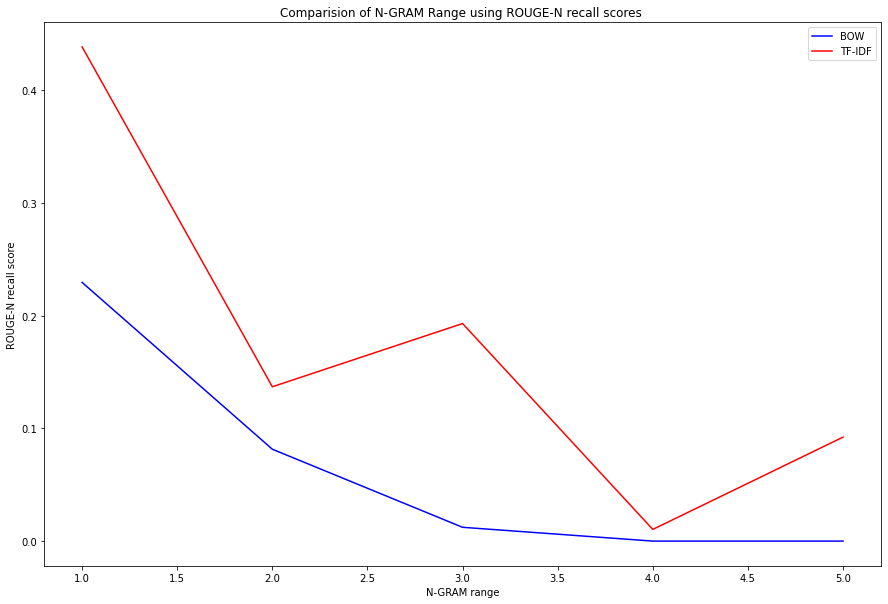

In [74]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

n_gram_range = [i for i in range(1,6)]

ax.plot(n_gram_range,comparision_df["BOW"],"b-")
ax.plot(n_gram_range,comparision_df["TF-IDF"],"r-")

ax.title.set_text("Comparision of sliding window Range using ROUGE-N recall scores ")
ax.set_xlabel("N-GRAM range")
ax.set_ylabel("ROUGE-N recall score")

plt.legend(["BOW", "TF-IDF"])

plt.show()

## Generate Features using Word-Embeddings (Next On Line)

In [15]:
pp_article_st[0:3]

['coordinate 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession',
 '3 8 million square mile 9 8 million square kilometer world third fourth largest country total area']

In [16]:
pp_article_st_wt = [word_tokenize(sent) for sent in pp_article_st]

In [72]:
#initialize word to vec
w2v_model = Word2Vec(min_count = 5, 
                     window = 5,
                     vector_size=10,
                     sample=6e-5,
                     alpha=0.001,
                     min_alpha = 0.0007,
                     negative=10,
                     workers=num_cores-2)

In [73]:
w2v_model.build_vocab(pp_article_st_wt,progress_per=10000)

In [74]:
w2v_model.train(pp_article_st_wt, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(23049, 265890)

In [75]:
#see embeddings for gas
w2v_model.wv["gas"]

array([ 0.08652357, -0.00291113,  0.0564789 ,  0.09214391,  0.04111112,
       -0.07119928, -0.01912575,  0.00989045,  0.02022973,  0.02952237],
      dtype=float32)

In [76]:
print(w2v_model.wv.vectors.shape)

(391, 10)


In [77]:
w2v_model.wv["state"]

array([-0.00499412,  0.00195046,  0.05175479,  0.09014327, -0.09295654,
       -0.0711713 ,  0.06534321,  0.09028207, -0.05078446, -0.03773032],
      dtype=float32)

In [78]:
#w2v_model.wv.key_to_index

In [79]:
type(w2v_model.wv.key_to_index)

dict

In [80]:
#if "state" in w2v_model.wv.key_to_index:
#    print("Yes")

In [81]:
w2v_model.wv["gas"]

array([ 0.08652357, -0.00291113,  0.0564789 ,  0.09214391,  0.04111112,
       -0.07119928, -0.01912575,  0.00989045,  0.02022973,  0.02952237],
      dtype=float32)

In [82]:
#w2v_model.wv.similarity("gas", "electric")

In [83]:
words = list(w2v_model.wv.index_to_key)

In [84]:
len(words)

391

In [96]:
word_emb_list = sorted(words)
word_emb_hash = set(word_emb_list)

In [92]:
word_emb_list[35: 40]

['8', '9', 'according', 'across', 'act']

## Create Scikit leanr pipe line --> from sklearn.pipeline import Pipeline:-->preprocessing-->BOW/TFIDF/WordEmbeddings/----> LSA/LDA

In [ ]:
#inputgiven documents---->

input_document = ["I am enjoying this movie",
"We cannot go from here to there at any time"]

#given embeddings of words:
#hashed acess already exists

#create feature vector


In [94]:
#we_df = pd.DataFrame(np.zeros(shape=(len(pp_article_st), len(word_emb_list))))
#we_df.columns = word_emb_list

In [98]:
"""
def generate_embedding_vector(single_sentence):
    word_tokens = word_tokenize(single_sentence)
"""

'\ndef generate_embedding_vector(single_sentence):\n    word_tokens = word_tokenize(single_sentence)\n'